# Customer Product Review: Sentiment Analysis
-----
-----

## Importing libraries

In [1]:
import string
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
import plotly.express as px
import warnings

from sklearn.svm import LinearSVC
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import accuracy_score,classification_report
from sklearn.linear_model import SGDClassifier
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
warnings.filterwarnings("ignore")

## Reading dataset
------

In [2]:
dataset = pd.read_csv('GrammarandProductReviews.csv')
dataset.head(2)

id            brand  \
0  AV13O1A8GV-KLJ3akUyj  Universal Music   
1  AV14LG0R-jtxr-f38QfS         Lundberg   

                                          categories             dateAdded  \
0  Movies, Music & Books,Music,R&b,Movies & TV,Mo...  2017-07-25T00:52:42Z   
1  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...  2017-07-25T05:16:03Z   

            dateUpdated          ean  \
0  2018-02-05T08:36:58Z  6.02537E+11   
1  2018-02-05T11:27:45Z  73416000391   

                                                keys  \
0  602537205981,universalmusic/14331328,universal...   
1  lundbergorganiccinnamontoastricecakes/b000fvzw...   

                         manufacturer manufacturerNumber  \
0  Universal Music Group / Cash Money           14331328   
1                            Lundberg             574764   

                                         name  ...   reviews.id  \
0   Pink Friday: Roman Reloaded Re-Up (w/dvd)  ...          NaN   
1  Lundberg Organic Cinnamon Toast Rice Cakes  ...  100209113.0   

  reviews.numHelpful reviews.rating  \
0                0.0              5   
1                NaN              5   

                                  reviews.sourceURLs  \
0  https://redsky.target.com/groot-domain-api/v1/...   
1   https://www.walmart.com/reviews/product/29775278   

                                        reviews.text  reviews.title  \
0  i love this album. it's very good. more to the...   Just Awesome   
1  Good flavor. This review was collected as part...           Good   

   reviews.userCity  reviews.userProvince reviews.username          upc  
0       Los Angeles                   NaN           Joshua  6.02537E+11  
1               NaN                   NaN        Dorothy W  73416000391  

[2 rows x 25 columns]

In [3]:
# checking shape of the dataset
dataset.shape

(71044, 25)

In [4]:
#checking null values
dataset.isnull().sum()

id                          0
brand                       0
categories                  0
dateAdded                   0
dateUpdated                 0
ean                     31979
keys                        0
manufacturer              141
manufacturerNumber        203
name                        0
reviews.date               67
reviews.dateAdded           0
reviews.dateSeen            0
reviews.didPurchase     38886
reviews.doRecommend     10615
reviews.id              38886
reviews.numHelpful      38536
reviews.rating              0
reviews.sourceURLs          0
reviews.text               36
reviews.title             476
reviews.userCity        65634
reviews.userProvince    70595
reviews.username           96
upc                         2
dtype: int64

## Data Cleaning:
------

### Selecting Required Columns:

In [5]:
data = dataset[['name','brand','reviews.didPurchase','reviews.rating', 'reviews.text']]

### Checking Null values:

In [6]:
data.isnull().sum()

name                       0
brand                      0
reviews.didPurchase    38886
reviews.rating             0
reviews.text              36
dtype: int64

### Inputing null values on 'reviews.didpurchase' & Removing all the null values:

In [7]:
data['reviews.didPurchase'] = data['reviews.didPurchase'].fillna('Not Avialable') 

In [8]:
data = data.dropna()

NumExpr defaulting to 2 threads.


## Text Cleaning 

In [9]:
def clean_text(text):
    """Make text lowercase, 
       remove text in angle brackets,
       remove \n,
       remove punctuation and 
       remove words containing numbers."""
    # lower case
    text = str(text).lower() 
    
    # remove text in angle brackets
    text = re.sub('<.*?>+', '', text).strip()
    
    # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text).strip()
    
    #remove newline character
    text = re.sub('\n', ' ', text).strip()
    
    # remove words containing numbers
    text = re.sub('\w*\d\w*', '', text).strip()
    
    return text

In [10]:
data['reviews.text']=data['reviews.text'].apply(lambda x:clean_text(x))
for i in enumerate(data['reviews.text'].head(2)):
    print(f'review {i}')

review (0, 'i love this album its very good more to the hip hop side than her current pop sound so hype i listen to this everyday at the gym i give it  rating all the way her metaphors are just crazy')
review (1, 'good flavor this review was collected as part of a promotion')


***Hurray !!! text data has been cleaned.***

## Visualizing The Result:
----

### Review Ratings Distribution:
-----

In [ ]:
#Find Shoppers satisfaction

Text(0.5, 1.0, 'Review Ratings Distribution')

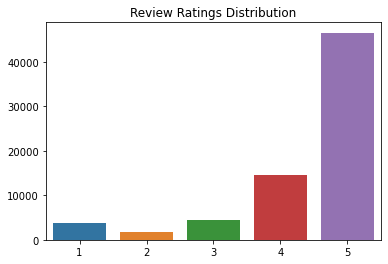

In [11]:
df = data['reviews.rating'].value_counts()
sns.barplot(x=df.index, y=df.values).set_title("Review Ratings Distribution")

- 65 % products have ratings 5 , 20 % have 4, 6% have 3 and rest have 1 & 2. 
- Need to map 1,2 - Unhappy, 3-OK and 4,5 - Happy

**Shoppers are very much satisfied with the products as the ratings high.**


### Fake Reviews Provided by User:
-----

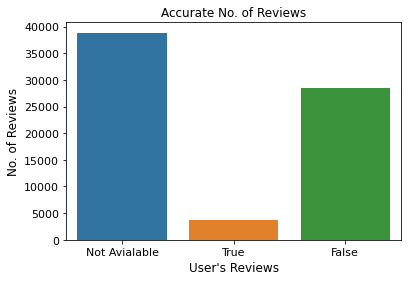

In [12]:
ax_plt = sns.countplot(data['reviews.didPurchase'])
ax_plt.set_xlabel(xlabel="User's Reviews",fontsize=12)
ax_plt.set_ylabel(ylabel='No. of Reviews',fontsize=12)
ax_plt.axes.set_title('Accurate No. of Reviews',fontsize=12)
ax_plt.tick_params(labelsize=11)

**True reviews are less in number and as you can see poeple who didn't even purchase the product has provided reviews these are all fake reviews which are much higher than those who have purchased and provided the review.**

## Finding top rated product names 

In [13]:
#Find the most popular product that shoppers have purchased
top=data[['brand','name','reviews.rating','reviews.text']][dataset['reviews.rating']==5]

In [14]:
top10_products = pd.DataFrame(top.groupby(by='name')['reviews.rating'].count().nlargest(10).sort_values(ascending = True))
fig = px.bar(top10_products, x = 'reviews.rating', y = top10_products.index, height = 600, color = 'reviews.rating', orientation = 'h',
            color_continuous_scale = ['deepskyblue','red'], title = 'Top 10 product based on rating equal to 5')
fig.show()

In [15]:
top10_brands = pd.DataFrame(top.groupby(by='brand')['reviews.rating'].count().nlargest(10).sort_values(ascending = True))
fig2 = px.bar(top10_brands, x = 'reviews.rating', y = top10_brands.index, height = 600, color = 'reviews.rating', orientation = 'h',
            color_continuous_scale = ['deepskyblue','red'], title = 'Top 10 brand based on rating equal to 5')
fig2.show()

In [16]:
print("No. of unique products -", top['name'].nunique())
print('No. of unique brands -', top['brand'].nunique())

No. of unique products - 543
No. of unique brands - 358


## Finding top 3 reason for the top most rated product

In [17]:
#Find 3 reasons in top-rated comments why people liked it.
top1_prod = pd.DataFrame(top.groupby(by='name')['reviews.rating'].count().nlargest(1).sort_values(ascending = False))
top3 = pd.DataFrame(top[top['name']=='Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total'])
top3[:5]

brand                                               name  \
7984  Clorox  Clorox Disinfecting Wipes Value Pack Scented 1...   
7985  Clorox  Clorox Disinfecting Wipes Value Pack Scented 1...   
7986  Clorox  Clorox Disinfecting Wipes Value Pack Scented 1...   
7987  Clorox  Clorox Disinfecting Wipes Value Pack Scented 1...   
7988  Clorox  Clorox Disinfecting Wipes Value Pack Scented 1...   

      reviews.rating                                       reviews.text  
7984               5  very convenient and efferctive germ fighter it...  
7985               5  my husband does leather tooling and gets leath...  
7986               5  i cannot live without those i have them on eve...  
7987               5  i love using clorox wipes to clean my bathroom...  
7988               5  i love how i feel after cleaning using clorox ...

## 1.Bag of word: vectors word frequency(count)


In [18]:
#tokenizer to remove unwanted elements from data like symbols
from nltk.tokenize import RegexpTokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

cv = CountVectorizer(lowercase=True,
                     stop_words='english',
                     ngram_range = (3,3),
                     tokenizer = token.tokenize)

In [19]:
text_counts= cv.fit_transform(top3['reviews.text'])
print(text_counts.shape)

(7210, 48407)


In [20]:
count_df = pd.DataFrame(text_counts.toarray(),columns=cv.get_feature_names())
count_df.head()

aalot mess esay  aanyhwere review collected  abilities makes easier  \
0                0                           0                       0   
1                0                           0                       0   
2                0                           0                       0   
3                0                           0                       0   
4                0                           0                       0   

   abilities review collected  ability clean counter  ability clean review  \
0                           0                      0                     0   
1                           0                      0                     0   
2                           0                      0                     0   
3                           0                      0                     0   
4                           0                      0                     0   

   ability clean sanitize  ability disinfect review  ability easy use  \
0                       0                         0                 0   
1                       0                         0                 0   
2                       0                         0                 0   
3                       0                         0                 0   
4                       0                         0                 0   

   ability fight stains  ...  yucky viruses left  yummy clean leaves  \
0                     0  ...                   0                   0   
1                     0  ...                   0                   0   
2                     0  ...                   0                   0   
3                     0  ...                   0                   0   
4                     0  ...                   0                   0   

   yyears old son  zap review collected  zero clorox wipes  ziploc bag purse  \
0               0                     0                  0                 0   
1               0                     0                  0                 0   
2               0                     0                  0                 0   
3               0                     0                  0                 0   
4               0                     0                  0                 0   

   ziplock bag handy  zone making feel  zones plus love  zoo easyfast clean  
0                  0                 0                0                   0  
1                  0                 0                0                   0  
2                  0                 0                0                   0  
3                  0                 0                0                   0  
4                  0                 0                0                   0  

[5 rows x 48407 columns]

## 2. Generating N-grams and wordcloud

In [21]:
new = top3[['reviews.text','reviews.rating']]
new.shape

(7210, 2)

In [22]:
from gensim.parsing.preprocessing import remove_stopwords 
from collections import defaultdict
import gensim
import random

def remove_stopword(x):
    """Remove stopwords from the articles"""
    # import stopwords from gensim methods to stop_list variable
    gensim_stopwords = gensim.parsing.preprocessing.STOPWORDS 
    stopwords_list = list(set(gensim_stopwords))     
    stopwords = stopwords_list 
    return [word for word in x if word not in stopwords]


def generate_ngrams(new, n_gram=1):
    """Generate n-gram words"""
    ngrams = zip(*[new[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]


def top_n_grams(new,N=20,n_gram=1):
    new['temp_list'] = new['reviews.text'].apply(lambda x:str(x).split())

    new['temp_list_stopw'] = new['temp_list'].apply(lambda x:remove_stopword(x))

    new_unigrams = defaultdict(int)

    for i in new['temp_list_stopw']:
        for word in generate_ngrams(i,n_gram):
            new_unigrams[word] += 1


    new_unigrams_df = pd.DataFrame(sorted(new_unigrams.items(), key=lambda x: x[1])[::-1])

    

    # bar graph Plot of top 20 common unigram 
    
    fig, axes = plt.subplots(figsize=(12,8))

    plt.tight_layout()

    sns.barplot(y=new_unigrams_df[0].values[:N], x=new_unigrams_df[1].values[:N], color='green')

    axes.spines['right'].set_visible(False)
    axes.set_xlabel('')
    axes.set_ylabel('')
    axes.tick_params(axis='x', labelsize=12)
    axes.tick_params(axis='y', labelsize=12)
    axes.set_title(f'Top {N} most common {n_gram}-grams in top1 product reviews', fontsize=15)
    plt.show()
    return new_unigrams

# Plot word cloud
def col_func(word, font_size, position, orientation, font_path, random_state):
    colors = ['#b58900', '#cb4b16', '#dc322f', '#d33682', '#6c71c4',
              '#268bd2', '#2aa198', '#859900']
    return random.choice(colors)


def word_cloud(new_unigrams,ngram):
    fd = {
        'fontsize': '32',
        'fontweight' : 'normal',
        'verticalalignment': 'baseline',
        'horizontalalignment': 'center',
    }

    wc = WordCloud(width=2000, height=1000, collocations=False,
                   background_color="white",
                   color_func=col_func,
                   max_words=200,
                   random_state=np.random.randint(1, 8)).generate_from_frequencies(new_unigrams)

    fig, ax = plt.subplots(figsize=(12,8))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(str(ngram)+'-gram Words for top1 product', pad=24, fontdict=fd)
    plt.show()

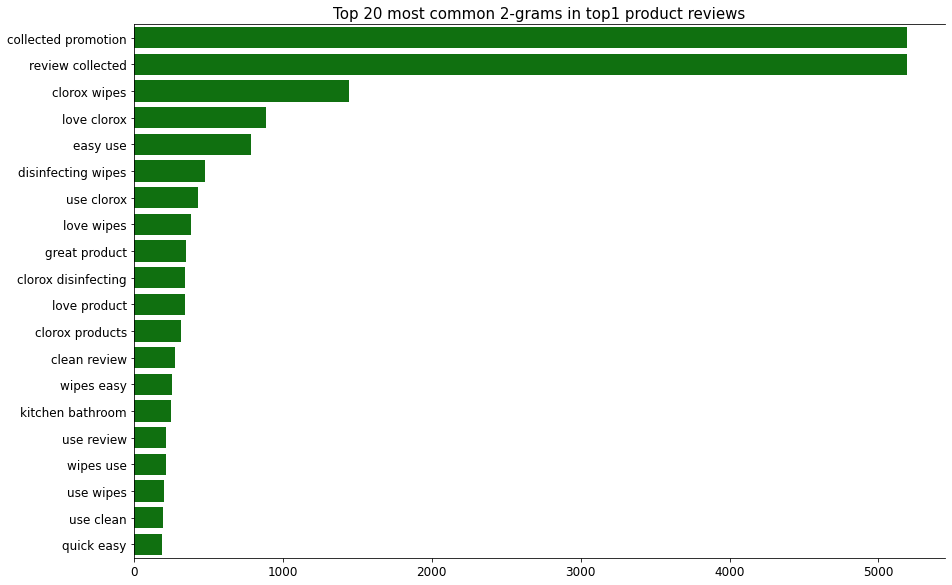

In [23]:
ngram=2
new_ngrams=top_n_grams(new,20,ngram)

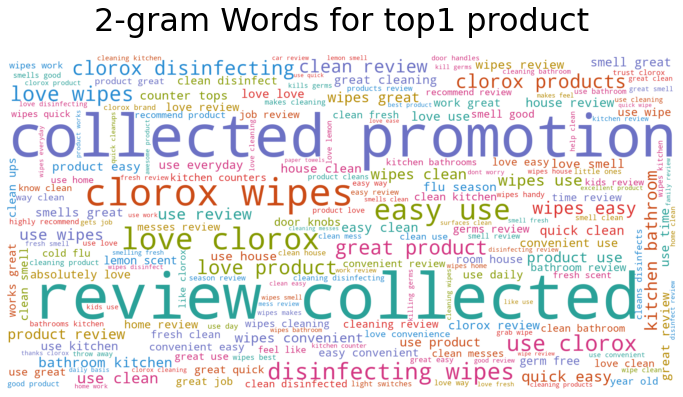

In [24]:
word_cloud(new_ngrams,ngram)

**From above ngram,wordcloud and BOW,top 3 reasons to purchase the Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total can be -**
- 1.Effectively clean everything i.e bathroom,kitchen & house clean mess etc.
- 2.Smells good lemon scent.
- 3.Easy to use & effective cost price.

## Overall reviews analysis

Find Frequent words in reviews

Text(0.5, 1.0, 'Length of reviews Vs Ratings')

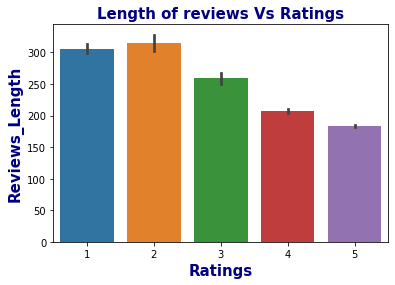

In [25]:
x = data['reviews.rating']
y = data['reviews.text'].apply(len)
ax = sns.barplot(y=y, x=x)
plt.xlabel('Ratings', fontsize=15, weight='bold', color='navy')
plt.ylabel('Reviews_Length', fontsize=15, weight='bold', color='navy')
plt.title('Length of reviews Vs Ratings', fontsize=15, weight='bold', color='navy')

In [26]:
new = data[['reviews.text','reviews.rating']]
new['length']=new['reviews.text'].apply(len)

In [27]:
def word_cloud(text):

    # Create stopword list
    stopword_list = set(STOPWORDS) 

    # Create WordCloud 
    word_cloud = WordCloud(width = 550, height = 550, 
                           background_color ='black', 
                           stopwords = stopword_list, 
                           min_font_size = 12).generate(text) 

    # Set wordcloud figure size
    plt.figure(figsize = (10, 10)) 

    # Show image
    plt.imshow(word_cloud) 

    # Remove Axis
    plt.axis("off")  

    # show plot
    plt.show()

### Create WordCloud for reviews according the satisfaction level

In [28]:
ratinglow = new[new['length']<50] 
a = ratinglow[ratinglow['reviews.rating']<3]

- Those have review length greater than 50 and having low rating don't show useful words so skipping them.
- Creating wordCloud for visualization

## Frequent words in Negative Reviews 

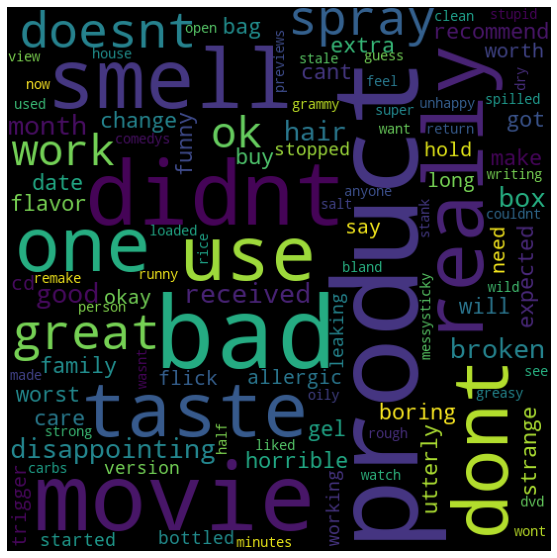

In [29]:
unhappy=' '.join(a["reviews.text"].tolist())
word_cloud(unhappy)

In the above word cloud, we are showing the frequent keywords of negative reviews. we can see that the most frequent words such as product, horrible, stale, broken, bad, worst,unhappy etc.

In [30]:
ratinghigh= new[new['length']<50]
b= ratinghigh[ratinghigh['reviews.rating']>3]

- Those have review length greater than 50 and having lhigh rating don't show useful words so skipping them.
- Creating wordCloud for visualization

## Frequent words in Positive Reviews

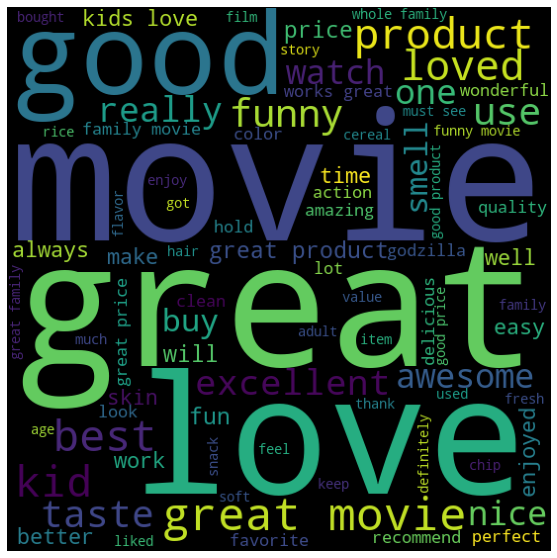

In [31]:
#happy reviews
happy=' '.join(b["reviews.text"].tolist())
word_cloud(happy)

In the above word cloud, we are showing the frequent keywords of positive reviews. we can see that the most frequent words such as great product,movie,taste good, excellent,amazing,fresh, love etc.

In [32]:
ratingOk = new[new['length']<150]
c=ratingOk[ratingOk['reviews.rating']==3]

- Those have review length greater than 150 and having Ok rating don't show useful words so skipping them.
- Creating wordCloud for visualization

## Frequent words in OK Reviews 

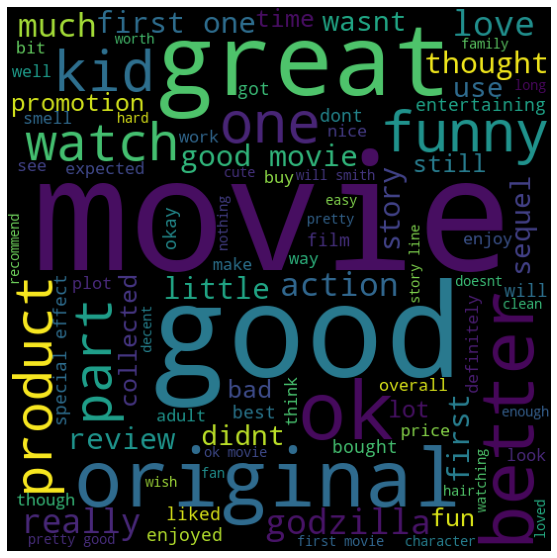

In [33]:
ok=' '.join(c["reviews.text"].tolist())
word_cloud(ok)

In the above word cloud, we are showing the frequent keywords of Ok reviews. we can see that the most frequent words such as mixed up of good and bad words like good,bad,ok etc.

> Now dataset is ready for making mo

## Supervised Machine learning model to predict ratings
-----

## Feature Transformation:
-----

In [34]:
df=data['reviews.text']
train_data=data['reviews.text']
y_target=data['reviews.rating'].map({1:'Unhappy',2:'Unhappy',3:'Ok',4:'Happy',5:'Happy'})

## Count Vectorizer

In [35]:
#tokenizer to remove unwanted elements from data like symbols

token = RegexpTokenizer(r'[a-zA-Z0-9]+')

cv = CountVectorizer(lowercase=True,
                     stop_words='english',
                     ngram_range = (1,1),
                     tokenizer = token.tokenize)

text_counts= cv.fit_transform(train_data)

print(text_counts.shape)

(71008, 34127)


In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(text_counts, 
                                                    y_target, 
                                                    test_size=0.3, 
                                                    random_state=1)

## Applying MultinomialNB

In [37]:
from sklearn.naive_bayes import MultinomialNB

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train, y_train)

predicted= clf.predict(X_test)

print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.8776228700183073


## Evaluate model

- Accuracy, Precision and Recall


In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
score1 = accuracy_score(y_test, predicted)
score2 = precision_score(y_test, predicted,average='weighted')
score3 = recall_score(y_test, predicted,average='weighted')
print("---- Scores ----")
print("Accuracy score is: {}".format(round(score1,2)))
print("Precision score is: {}".format(round(score2,2)))
print("Recall score is: {}".format(round(score3,2)))

---- Scores ----
Accuracy score is: 0.88
Precision score is: 0.86
Recall score is: 0.88


> **Hurray!!! Getting pretty much good accuracy model**

## Making the Confusion Matrix


In [39]:
from sklearn.metrics import confusion_matrix
nb = confusion_matrix(y_test, predicted)
nb

array([[17404,   337,   538],
       [ 1010,   149,   175],
       [  474,    73,  1143]], dtype=int64)

## Plotting the confusion matrix


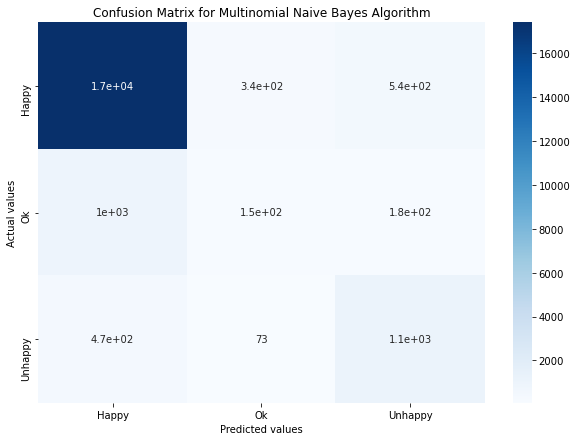

In [40]:
plt.figure(figsize=(10,7))
sns.heatmap(data=nb, annot=True, cmap="Blues", xticklabels=['Happy', 'Ok','Unhappy'], yticklabels=['Happy', 'Ok','Unhappy'])
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion Matrix for Multinomial Naive Bayes Algorithm')
plt.show()

### Making Predictions function

In [41]:
def prediction(text):
    # lower case
    text = str(text).lower() 
    
    # remove text in angle brackets
    text = re.sub('<.*?>+', '', text).strip()
    
    # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text).strip()
    
    #remove newline character
    text = re.sub('\n', ' ', text).strip()
    
    # remove words containing numbers
    text = re.sub('\w*\d\w*', '', text).strip()
    temp = cv.transform([text]).toarray()
    return clf.predict(temp)

### checking whether model predicts right or not

In [42]:
sample = "I love these! Yes, they are a bit more expensive than buying the liquid form, but they are worth every penny. I think I overuse the liquid, usually not even using the cup when I pour it into my washer. So these are perfect. I guarantee I'm saving money by using 1 of these per load. I read a review that said she had a problem with blue staining, I have never had a problem with that. My clothes come out great, with no problems. The smells are great, my favorite being the Ocean Mist. They are very convenient and I love the way they clean my clothes. Extremely happy and I would definitely recommend buying these.BUY! BUY! BUY!"
prediction(sample)

array(['Happy'], dtype='<U7')

In [43]:
sample2="I love this moisturizer. I thought at first that it would leave my skin oily but I have been using this for a little over a week and I am very impressed. I think this is the best moisturizer I have used, and I usually purchase one that is much more expensive. I am please with the overall feel of my skin after using. This review was collected as part of a promotion."
prediction(sample2)

array(['Happy'], dtype='<U7')

> **Our model is predicting right**

## TF-IDF

In [44]:
vectorize_word = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',analyzer='word',token_pattern=r'\w{1,}',stop_words='english',ngram_range=(1, 1),max_features=10000)
vectorize_word.fit(data)
train_features_word = vectorize_word.transform(train_data)

In [45]:
vectorize_char = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',analyzer='char',stop_words='english',ngram_range=(2, 6),max_features=50000)
vectorize_char.fit(data)
train_features_char = vectorize_char.transform(train_data)
train_features = hstack([train_features_char, train_features_word])

In [46]:
train_features.shape

(71008, 150)

In [47]:
train_features.data

array([0.19189438, 0.19189438, 0.19189438, ..., 1.        , 1.        ,
       1.        ])

In [48]:
X_train, X_test, y_train, y_test = train_test_split(train_features, y_target,test_size=0.3,random_state=101,shuffle=True)

## SVC Model:
----

In [49]:
lsvm = LinearSVC(class_weight='balanced')
l = lsvm.fit(X_train,y_train)

### Linear SVC Metric Over Training:

In [50]:
pred_train = l.predict(X_train)

In [51]:
print("Accuracy Train: {}".format(accuracy_score(y_train,pred_train)))
print(classification_report(y_train,pred_train))

Accuracy Train: 0.8353083190825873
              precision    recall  f1-score   support

       Happy       0.90      0.93      0.91     42837
          Ok       0.22      0.07      0.10      3026
     Unhappy       0.35      0.41      0.38      3842

    accuracy                           0.84     49705
   macro avg       0.49      0.47      0.47     49705
weighted avg       0.81      0.84      0.82     49705



### Linear SVC Metric Over Test:

In [52]:
pred_test=l.predict(X_test)

In [53]:
print("Accuracy Test : {}".format(accuracy_score(y_test,pred_test)))
print(classification_report(y_test,pred_test))

Accuracy Test : 0.8348589400553913
              precision    recall  f1-score   support

       Happy       0.89      0.93      0.91     18271
          Ok       0.20      0.06      0.09      1341
     Unhappy       0.37      0.40      0.39      1691

    accuracy                           0.83     21303
   macro avg       0.49      0.46      0.46     21303
weighted avg       0.81      0.83      0.82     21303



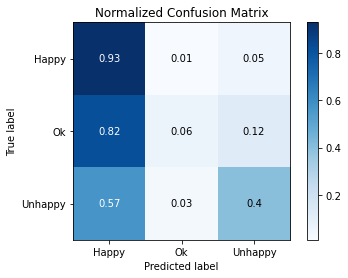

In [54]:
skplt.metrics.plot_confusion_matrix(y_test, pred_test, normalize=True)
plt.show()

## SGD Classifier:
----

In [55]:
svm1=SGDClassifier(class_weight='balanced',n_jobs=-1)
svm1.fit(X_train,y_train)

SGDClassifier(class_weight='balanced', n_jobs=-1)

### SGD Metric Over Training:

In [56]:
pred_train_sgd=svm1.predict(X_train)
print("Accuracy Train: {}".format(accuracy_score(y_train,pred_train_sgd)))
print(classification_report(y_train,pred_train_sgd))

Accuracy Train: 0.857298058545418
              precision    recall  f1-score   support

       Happy       0.88      0.97      0.92     42837
          Ok       0.00      0.00      0.00      3026
     Unhappy       0.39      0.23      0.29      3842

    accuracy                           0.86     49705
   macro avg       0.42      0.40      0.40     49705
weighted avg       0.79      0.86      0.82     49705



### SGD Metric Over Test:

In [57]:
pred_test_sgd=svm1.predict(X_test)
print("Accuracy Test: {}".format(accuracy_score(y_test,pred_test_sgd)))
print(classification_report(y_test,pred_test_sgd))

Accuracy Test: 0.8528845702483219
              precision    recall  f1-score   support

       Happy       0.87      0.97      0.92     18271
          Ok       0.33      0.00      0.00      1341
     Unhappy       0.40      0.22      0.28      1691

    accuracy                           0.85     21303
   macro avg       0.53      0.40      0.40     21303
weighted avg       0.80      0.85      0.81     21303



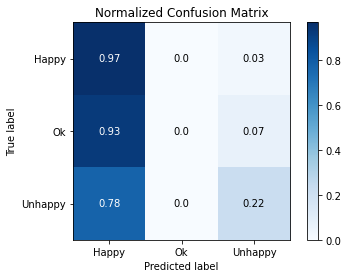

In [58]:
skplt.metrics.plot_confusion_matrix(y_test, pred_test_sgd, normalize=True)
plt.show()

## Unsupervised Learning on reviews.text

In [59]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [60]:
new = data[['reviews.text','reviews.rating']]
new['length']=new['reviews.text'].apply(len)
train= new[new['length']<50]
train = train["reviews.text"]
print(train.shape)

(3834,)


In [61]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , n_jobs = -1
                               , random_state = 1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

In [62]:
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

In [63]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = cv.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs


In [64]:
cv = CountVectorizer(lowercase=True,
                     stop_words='english',
                     ngram_range = (1,1),
                     tokenizer = token.tokenize)
transform= cv.fit_transform(train)

bow = pd.DataFrame(data = transform.toarray(), columns=cv.get_feature_names())

final_df = bow
transform.shape

(3834, 2371)

In [65]:
# # Running Kmeans
from sklearn import cluster
k = 8
kmeans_results = run_KMeans(k, final_df)

# # Plotting Silhouette Analysis
# #silhouette(kmeans_results, final_df, plot=True)

In [66]:
def plotWords(dfs, n_feats):
    
    plt.figure(figsize=(8, 4))
    
    for i in range(0, len(dfs)):
        
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=12,fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()


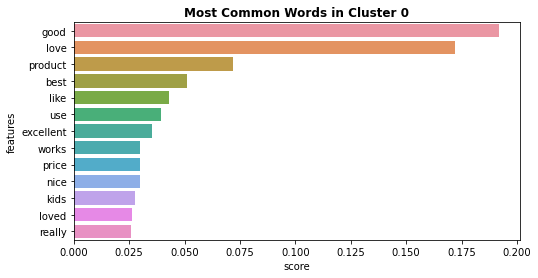

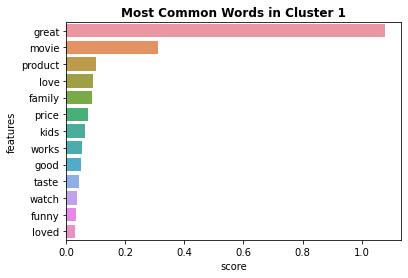

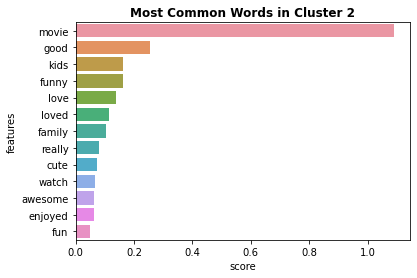

In [67]:
best_result = 3
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

In [68]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure(figsize=(10,10))
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

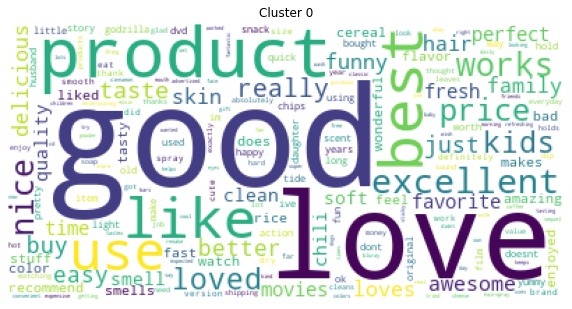

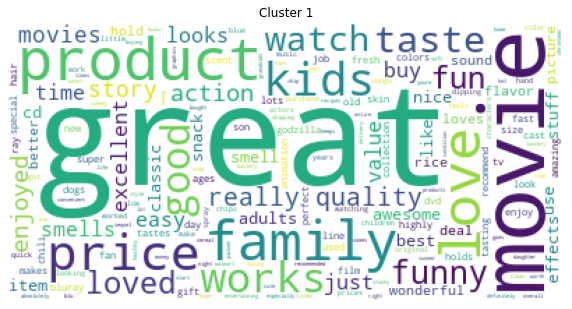

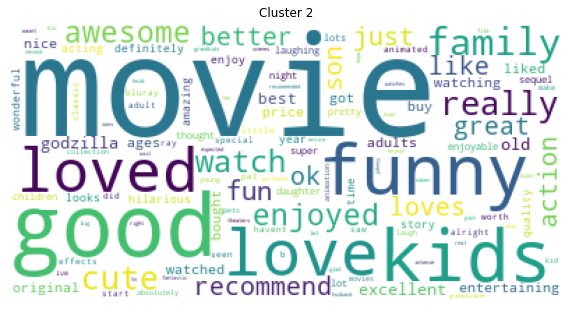

In [69]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = bow.columns
generateWordClouds(centroids)